In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
from tqdm import tqdm
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


batch_size=100
IMG_SIZE = 128
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on GPU')
else:
    device = torch.device('cpu')
    print('running on CPU')

running on GPU


In [1]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()

def setup():
   ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Cat_Dog_data.zip")
   ipython.magic("sx unzip -qq Cat_Dog_data.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


# Old approach of data preprocessing


In [ ]:
class DogsVSCats():
    IMG_SIZE = 128
    CATS = "/content/Cat_Dog_data/train/cat"
    DOGS = "/content/Cat_Dog_data/train/dog"

    TESTING_CATS = "/content/Cat_Dog_data/test/cat"
    TESTING_DOGS = "/content/Cat_Dog_data/test/dog"

    LABELS = {CATS: 0, DOGS: 1}
    LABELS_TEST = {TESTING_CATS: 0, TESTING_DOGS: 1}

    training_data = []
    testing_data = []

    catcount = 0
    dogcount = 0

    catcount_test = 0
    dogcount_test = 0

    def make_training_data(self):
        for label in self.LABELS:
            #print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print()
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
        print('------finish training set-----')


    def make_testing_data(self):
            for label_test in self.LABELS_TEST:
                #print(label)
                for f in tqdm(os.listdir(label_test)):
                    if "jpg" in f:
                        try:
                            path_test = os.path.join(label_test, f)
                            img = cv2.imread(path_test, cv2.IMREAD_GRAYSCALE)
                            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                            self.testing_data.append([np.array(img), np.eye(2)[self.LABELS_TEST[label_test]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                            #print(np.eye(2)[self.LABELS[label]])

                            if label_test == self.TESTING_CATS:
                                self.catcount_test += 1
                            elif label_test == self.TESTING_DOGS:
                                self.dogcount_test += 1

                        except Exception as e:
                            pass
                            #print(label, f, str(e))

            #np.random.shuffle(self.testing_data)
            np.save("testing_data.npy", self.testing_data)
            print()
            print('Cats_test:',dogsvcats.catcount_test)
            print('Dogs_test:',dogsvcats.dogcount_test)

In [ ]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    dogsvcats.make_testing_data()


  7%|▋         | 82/1250 [00:00<00:01, 811.39it/s]


Cats: 11250
Dogs: 11250
------finish training set-----


100%|██████████| 1250/1250 [00:01<00:00, 919.17it/s]



Cats_test: 1250
Dogs_test: 1250


In [ ]:
transformations = transforms.Compose([transforms.Resize(128),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

In [ ]:
training_data = np.load("training_data.npy",  allow_pickle=True)
print('training data set length: ',len(training_data), type(training_data))


training data set length:  22500 <class 'numpy.ndarray'>


In [ ]:
# Loading the downloaded training set
trainloader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=batch_size)

In [ ]:
testing_data = np.load("testing_data.npy", allow_pickle=True)
print('testing data set length: ',len(testing_data))

testing data set length:  2500


# New update model

In [ ]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

TypeError: ignored

In [ ]:
# Loading the downloaded testing set
testloader = torch.utils.data.DataLoader(testing_data, shuffle=False, batch_size=batch_size)

In [ ]:
train_X = torch.Tensor([i[0] for i in training_data]).view(-1, 128, 128) # ToTensor
train_X = train_X/255.0 #Normalize

train_y = torch.Tensor([i[1] for i in training_data])

In [ ]:
test_X = torch.Tensor([i[0] for i in testing_data]).view(-1, 128, 128) # ToTensor
test_X = test_X/255.0 #Normalize

test_y = torch.Tensor([i[1] for i in testing_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

#Look at training testing sizes

In [ ]:
print(len(train_X), len(train_y), 'train_X lenght, train_y lenght')
print(len(test_X), len(test_y), 'test_X lenght, test_y lenght')

22500 22500 train_X lenght, train_y lenght
2500 2500 test_X lenght, test_y lenght


# New data preprocessing

In [ ]:
data_dir = '/content/Cat_Dog_data'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['.DS_Store', 'test', 'train']
['.DS_Store', 'cat', 'dog']


In [ ]:
cats_train = os.listdir(data_dir + "/train/cat")
print('No. of training examples for cats:', len(cats_train))
print(cats_train[:5])

No. of training examples for cats: 11250
['cat.5767.jpg', 'cat.8351.jpg', 'cat.1327.jpg', 'cat.12292.jpg', 'cat.8308.jpg']


In [ ]:
cats_test = os.listdir(data_dir + "/test/cat")
print("No. of test examples for cats:", len(cats_test))
print(cats_test[:5])

No. of test examples for cats: 1250
['cat.1777.jpg', 'cat.5455.jpg', 'cat.9390.jpg', 'cat.10181.jpg', 'cat.5642.jpg']


In [ ]:
dogs_train = os.listdir(data_dir + "/train/dog")
print('No. of training examples for dogs:', len(dogs_train))
print(dogs_train[:5])

No. of training examples for dogs: 11250
['dog.1216.jpg', 'dog.1350.jpg', 'dog.12122.jpg', 'dog.11967.jpg', 'dog.4696.jpg']


In [ ]:
dogs_test = os.listdir(data_dir + "/test/dog")
print("No. of test examples for dogs:", len(dogs_test))
print(dogs_test[:5])

No. of test examples for dogs: 1250
['dog.4144.jpg', 'dog.1876.jpg', 'dog.1529.jpg', 'dog.1634.jpg', 'dog.584.jpg']


## Transformations

In [ ]:
transformations = transforms.Compose([transforms.Resize(128),
                               transforms.RandomCrop(128),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5,))]) 

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=transformations)
print(len(dataset))
print(type(dataset))

22500
torchvision.datasets.folder.ImageFolder


In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([1, 128, 128]) 0


tensor([[[ 0.0745,  0.1922,  0.2392,  ...,  0.6471,  0.6314,  0.6157],
         [ 0.2157,  0.2706,  0.2863,  ...,  0.6549,  0.6392,  0.6235],
         [ 0.3176,  0.2784,  0.2863,  ...,  0.6627,  0.6471,  0.6314],
         ...,
         [-0.6314, -0.6314, -0.6235,  ..., -0.9765, -0.9765, -0.9765],
         [-0.6471, -0.6471, -0.6392,  ..., -0.9765, -0.9765, -0.9765],
         [-0.6549, -0.6549, -0.6471,  ..., -0.9843, -0.9843, -0.9843]]])

In [ ]:
print(dataset.classes)

['cat', 'dog']


In [ ]:
testdata = ImageFolder(data_dir+'/test', transform=transformations)
print(len(testdata))
print(type(testdata))

2500
torchvision.datasets.folder.ImageFolder


In [ ]:
img, label = testdata[0]
print(img.shape, label)
img

torch.Size([1, 128, 128]) 0


tensor([[[ 0.5451,  0.5608,  0.5608,  ...,  0.5451,  0.5451,  0.5451],
         [ 0.5451,  0.5608,  0.5608,  ...,  0.5529,  0.5451,  0.5451],
         [ 0.5451,  0.5608,  0.5608,  ...,  0.5529,  0.5529,  0.5529],
         ...,
         [-0.1608, -0.2392, -0.4824,  ..., -0.0667, -0.0980, -0.1216],
         [-0.1529, -0.2314, -0.4745,  ..., -0.0275, -0.0824, -0.1216],
         [-0.1529, -0.2471, -0.4745,  ...,  0.0118, -0.0588, -0.0980]]])

In [ ]:
print(testdata.classes)

['cat', 'dog']


## Plot images

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(torchvision.utils.make_grid(img, nrow=5).permute(1, 2, 0))
    #plt.imshow(img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cat (0)


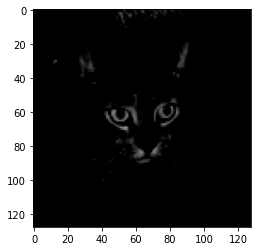

In [ ]:
show_example(*dataset[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cat (0)


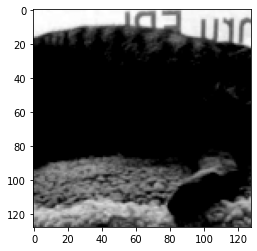

In [ ]:
show_example(*testdata[1])

## Dataloader

In [ ]:
train_dl = DataLoader(dataset, batch_size, shuffle=True) #, num_workers=0, pin_memory=True)
test_dl = DataLoader(testdata, batch_size, shuffle=False) #, num_workers=0, pin_memory=True)


## Show batches of images 

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 50))#50,100
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


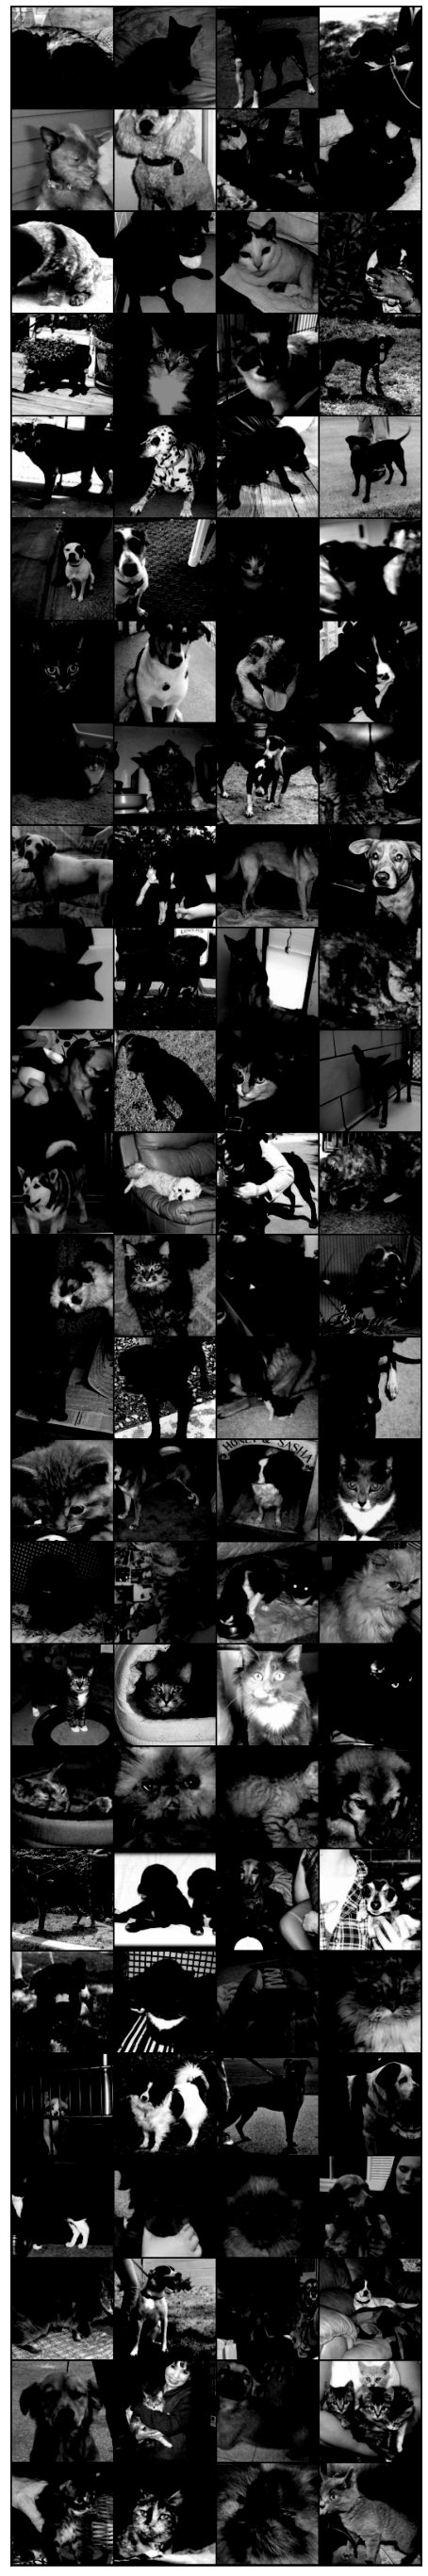

In [ ]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


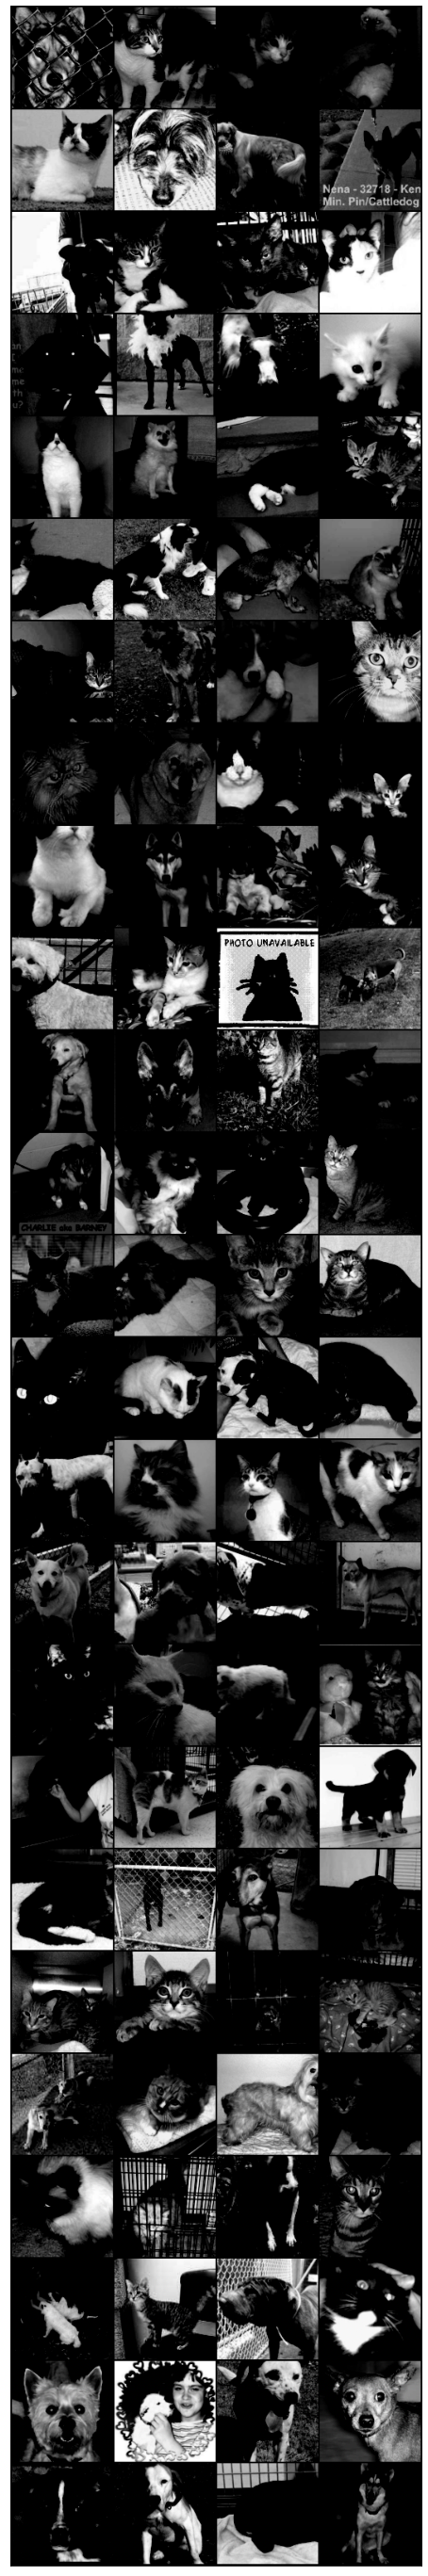

In [ ]:
show_batch(test_dl)

#Build the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.bn1 = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.bn3 = nn.BatchNorm2d(128)
        #self.conv4 = nn.Conv2d(128, 256, 5)
        #self.bn4 = nn.BatchNorm2d(256)

        x = torch.randn(IMG_SIZE,IMG_SIZE).view(-1,1,IMG_SIZE,IMG_SIZE) # 1 is the number of images in the input
        self._to_linear = None
        self.convs(x)


        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 216)
        self.fc3 = nn.Linear(216, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        #x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))

        i = 0
        if i < 1:
            i+= 1
            print(x[0].shape)
            
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1) # 1 between cats and dogs while 0 between all batches


In [ ]:
net = Net().to(device) # move to GPU

torch.Size([128, 12, 12])


In [ ]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18432, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=2, bias=True)
)


#Improvement on code

##We definitely do not want to modify weights when we do our validation data, for example. For this reason, to default this to be False.

In [ ]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

#Eval method called in train method

In [ ]:
def test(size=32):
    for test_X, test_y in test_dl:

        X, y = test_X[:size], test_y[:size]
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 128, 128).to(device), y.to(device))
        return val_acc, val_loss

In [ ]:
val_acc, val_loss = test(size=batch_size)
print(val_acc, val_loss)

torch.Size([128, 12, 12])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
for images, label in train_dl:
    print('images.shape:', images.shape, ' label is ', len(label))
    print(images)
    break

#Initialization


In [ ]:
import time
lr=0.001
EPOCHS = 25

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_function = nn.MSELoss()

print(MODEL_NAME)


torch.Size([128, 12, 12])
model-1607715788


#Training and calling testing method

In [ ]:
def train(net):
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            i = 0
            #for i in tqdm(range(0, len(train_dl), BATCH_SIZE)):
            for images, labels in train_dl:
                i +=1

                batch_X = images[i:i+batch_size].view(-1,1,128,128).to(device)
                batch_y = labels[i:i+batch_size].to(device)
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 10 == 0:
                    val_acc, val_loss = test(size=batch_size)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n") #{epoch}
            print(("\n Model observations:\n , Accuracy: {acc}  Loss: {loss}. " + 
            "Val_acc: {val_acc} val_loss: {val_loss}") \
            .format(acc=acc, loss=loss,val_acc=val_acc, val_loss=val_loss))

In [ ]:
train(net)

torch.Size([128, 12, 12])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

#Plotting


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
model_name =  'model-1607570171'# 'model-1607572426' "model-1607567311" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


In [ ]:
def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(',')
            #model-1607558164,1607558266.975,0.84,0.1127,0.81,0.1514
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

    print(("\n Model observations:\n , Accuracy: {acc}  Loss: {loss}. " + 
            "Val_acc: {val_acc} val_loss: {val_loss}") \
            .format(acc=acc, loss=loss,val_acc=val_acc, val_loss=val_loss))

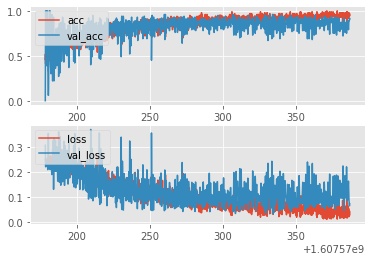


 Model observations:
 , Accuracy: 0.95  Loss: 0.0412. Val_acc: 0.91 val_loss: 0.0734


In [ ]:
create_acc_loss_graph(model_name)

#Observations
1. In-sample accuracy: This is the accuracy on the data we're actually feeding through the model for training. This is the data that we're "fitting" against.


2. Out-of-sample accuracy: This is the accuracy on data that we've set aside that the model will never see/fit against.

##**In general, we expect in-sample accuracy(training accuracy) to be higher than out-of-sample accuracy(validation accuracy).**

1. While we expect validation/out-of-sample accuracy to be a bit worse than the in-sample accuracy, we want to track that delta.

2. Something like 5-10% accuracy difference is pretty common, but as this delta grows, it usually signals to us that our model is beginning to "overfit" (the neural network is just memorizing the data and changing weights to work only for the training data, rather than generally understanding the data).

3. By tracking the out of sample loss. We will often be able to spot both losses decline to a point, and then **out of sample** loss **begins to arc** and curve back upwards. This is usually a sign that you've gotten the most out of your model's training.






